In [1]:
from os import walk 
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt 

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline 
#jupnotebook specific for DL jpnotebook 

In [2]:
SPAM_1_FILEPATH = 'spam_1'
SPAM_2_FILEPATH= 'spam_2'
HAM_1_FILEPATH = 'ham_1'
HAM_2_FILEPATH = 'ham_2'

SPAM_CAT = 1
HAM_CAT = 0

CUSTOM_FONT = 'wordcloud_resources/OpenSansCondensed-Bold.ttf'
WORD_CLOUD = 'wordcloud_resources/word_cloud.png'
THUMBS_UP = 'wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = 'wordcloud_resources/thumbs-down.png'

In [3]:
def email_body_generator(path): 
                                    #walk provides a tuple 
    for root, dirnames, filenames, in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body= False
            lines = []
            
            #extracts email body 
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            #loops over the file in the directory and returns the file name and associated email body 
            yield file_name, email_body

In [4]:
def dataframe_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name) 
    
    return pd.DataFrame(rows, index=row_names) 

In [5]:
spam_emails = dataframe_from_directory(SPAM_1_FILEPATH, SPAM_CAT)
spam_emails = spam_emails.append(dataframe_from_directory(SPAM_2_FILEPATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [6]:
ham_emails = dataframe_from_directory(HAM_1_FILEPATH, HAM_CAT)
ham_emails = ham_emails.append(dataframe_from_directory(HAM_2_FILEPATH, HAM_CAT))


In [7]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of whole dataframe is ', data.shape)

Shape of whole dataframe is  (5799, 2)


In [8]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [9]:
data.drop(['cmds'], inplace = True)

In [10]:
documents_ids = range(0, len(data.index))
data['Doc_ID'] = documents_ids

In [11]:
data['File_Name'] = data.index

In [12]:
data = data.set_index('Doc_ID')

In [13]:
#data.to_json(DATA_JSON_FILE)

In [14]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [15]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

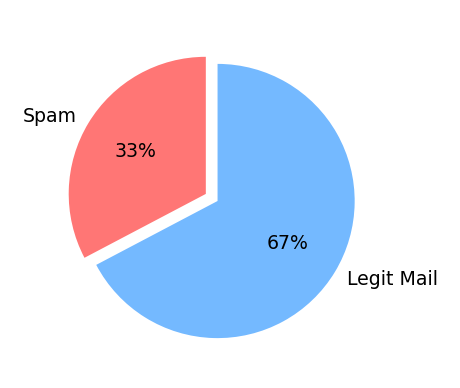

In [16]:
category_names =['Spam', 'Legit Mail']
size = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(size, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours, explode=[0,0.1])
plt.show()

In [17]:
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachaeldoherty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
capital_sw = [each_string.title() for each_string in sw]
uppercase_sw = [each_string.upper() for each_string in sw]
new_words = ['http', 'br', 'ign', 'err', 'mpt']

sw.extend(new_words)
sw.extend(capital_sw)
sw.extend(uppercase_sw)

In [19]:
stop_words = set(sw)

In [20]:
len(stop_words)

534

In [21]:
def clean_msg_nohtml(message, #stemmer = PorterStemmer(),
                  stop_words = set(stopwords.words('english'))): 
    
    # Remove HTML tags 
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    #Converts to lower case and splots up  the individual words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    
    return filtered_words

In [22]:
%%time

## apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_nohtml)

/Users/rachaeldoherty/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 16.3 s, sys: 37 ms, total: 16.3 s
Wall time: 16.3 s


In [23]:
nested_list.head()

Doc_ID
0    [dear, homeowner, interest, rates, lowest, poi...
1    [attention, must, computer, users, package, de...
2    [message, mime, format, dare, try, find, bette...
3    [important, information, new, domain, names, f...
4    [bottom, line, give, away, cd, free, people, l...
Name: MESSAGE, dtype: object

In [24]:
docs_id_SPAM = data[data.CATEGORY ==1].index
docs_id_HAM = data[data.CATEGORY ==0].index

In [25]:
nested_list_HAM = nested_list.loc[docs_id_HAM]
nested_list_SPAM = nested_list.loc[docs_id_SPAM]

In [26]:
flat_list_HAM = [item for sublist in nested_list_HAM for item in sublist]
HAM_words = pd.Series(flat_list_HAM).value_counts() #total number of unique words in the non spam messages

HAM_words.shape[0] #total number of words


30098

In [27]:
HAM_words[:10]

http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64

In [28]:
flat_list_SPAM = [item for sublist in nested_list_SPAM for item in sublist]
#total number of unique words in the spam messages
SPAM_words = pd.Series(flat_list_SPAM).value_counts() 
#total number of words in spam messages
SPAM_words.shape


(18022,)

In [29]:
SPAM_words[:10]

http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64

In [30]:
flat_list_SPAM

['dear',
 'homeowner',
 'interest',
 'rates',
 'lowest',
 'point',
 'years',
 'help',
 'find',
 'best',
 'rate',
 'situation',
 'matching',
 'needs',
 'hundreds',
 'lenders',
 'home',
 'improvement',
 'refinance',
 'second',
 'mortgage',
 'home',
 'equity',
 'loans',
 'even',
 'less',
 'perfect',
 'credit',
 'service',
 'free',
 'home',
 'owners',
 'new',
 'home',
 'buyers',
 'without',
 'obligation',
 'fill',
 'quick',
 'simple',
 'form',
 'future',
 'plans',
 'today',
 'visit',
 'http',
 'unsubscribe',
 'please',
 'visit',
 'http',
 'attention',
 'must',
 'computer',
 'users',
 'package',
 'deal',
 'norton',
 'systemworks',
 'software',
 'suite',
 'includes',
 'six',
 'yes',
 'utilities',
 'special',
 'low',
 'price',
 'software',
 'protect',
 'computer',
 'unwanted',
 'hazardous',
 'viruses',
 'help',
 'secure',
 'private',
 'valuable',
 'information',
 'allow',
 'transfer',
 'files',
 'send',
 'safely',
 'backup',
 'data',
 'quick',
 'easily',
 'improve',
 'pc',
 'performance',
 'i

In [31]:
SPAM_str = ' ' .join(flat_list_SPAM)
HAM_str = ' ' .join(flat_list_HAM)

In [32]:
full_str = SPAM_str + HAM_str

In [33]:
len(HAM_str)

3111573

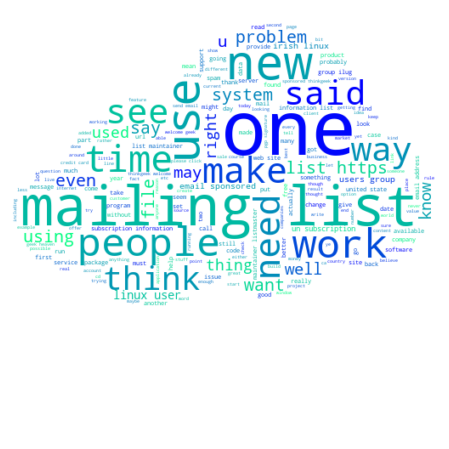

In [34]:
icon = Image.open(WORD_CLOUD)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 200, colormap = 'winter')

word_cloud.generate(full_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

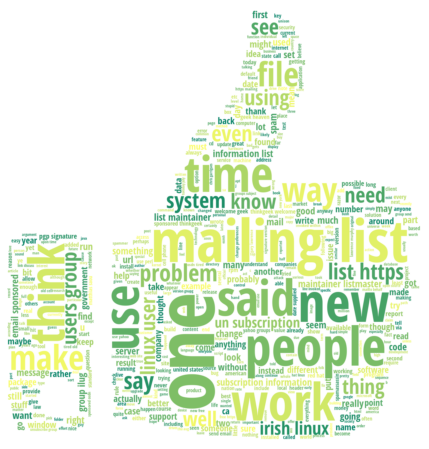

In [35]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 


word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'summer',
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(HAM_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

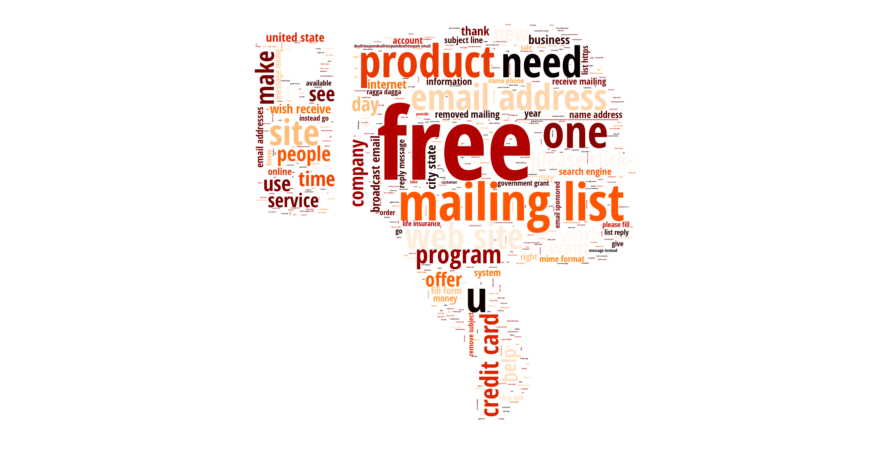

In [36]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'gist_heat', 
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(SPAM_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()